In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, AdamW, RAdam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss, BCEWithLogitsLoss
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear, Dropout
from torch import cat
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

d:\miniconda3\Lib\site-packages\pennylane\__init__.py:196: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.0 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])


train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)


train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

batch_size = 50

binary_train_ds = Subset(train_ds, train_idx)
train_loader = DataLoader(binary_train_ds, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [38]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = Conv2d(8, 25, kernel_size=5, padding=2)
        self.dropout = Dropout2d()
        self.fc1 = Linear(25 * 7 * 7, 36)
        self.fn_dropout = Dropout(p=0.1)
        self.fc2 = Linear(36, 4)
        self.fc3 = Linear(4, 1)

        # Quantum layer
        self.num_q_wires = 4
        self.q_device = qml.device("default.qubit", wires=self.num_q_wires)
        
        self.num_q_layers = 2
        qnn_params_size = (self.num_q_layers * 1 + 1) * self.num_q_wires
        qnn_params_tensor = torch.empty(qnn_params_size, requires_grad=True)

        # Kaiming 초기화의 gain 값 계산 (SiLU에 적합한 'leaky_relu'를 사용)
        gain = torch.nn.init.calculate_gain('leaky_relu')
        std = gain / qnn_params_size**0.5 # 텐서 크기를 이용한 표준 편차 계산
        
        # 균등 분포로 파라미터 초기화
        torch.nn.init.uniform_(qnn_params_tensor, -std, std)

        self.qnn_params = Parameter(qnn_params_tensor)

        #@qml.qnode(self.q_device)
        @qml.qnode(self.q_device, interface="torch")
        def circuit(x_batch):
            param_idx = 0 
            for layer in range(self.num_q_layers): # num_q_layers 만큼 반복
                for i in range(self.num_q_wires):
                    qml.H(wires=i)
                    qml.RY(2. * x_batch[:, i], wires=i)
                    
                for i in range(self.num_q_wires):
                    qml.CRY(2. * (torch.pi - x_batch[:, i]) * (torch.pi - x_batch[:, (i+1) % self.num_q_wires]), wires=[i, (i+1)%self.num_q_wires])

                # EfficientSU2
                for i in range(self.num_q_wires):
                    qml.RY(self.qnn_params[param_idx], wires=i)
                    param_idx += 1

                for i in range(self.num_q_wires):
                    qml.CNOT(wires=[i, (i+1)%self.num_q_wires])

                
                if layer == self.num_q_layers-1:
                    for i in range(self.num_q_wires):
                        qml.RY(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
            
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_q_wires)]

        self.qnn = circuit

    def forward(self, x):
        #x = F.silu(self.conv1(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        #x = F.silu(self.conv2(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        
        #x = F.silu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x))
        #x = F.dropout(x, p=0.1)
        x = self.fn_dropout(x)

        x = self.fc2(x)
        
        #x = self.qnn(x).view(1,)  # apply QNN
        qnn_out = self.qnn(x) 
        x = torch.stack(qnn_out, dim=-1).to(x.device)
        
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

bc = BinaryClassifier()
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1225, out_features=36, bias=True)
  (fn_dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=36, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

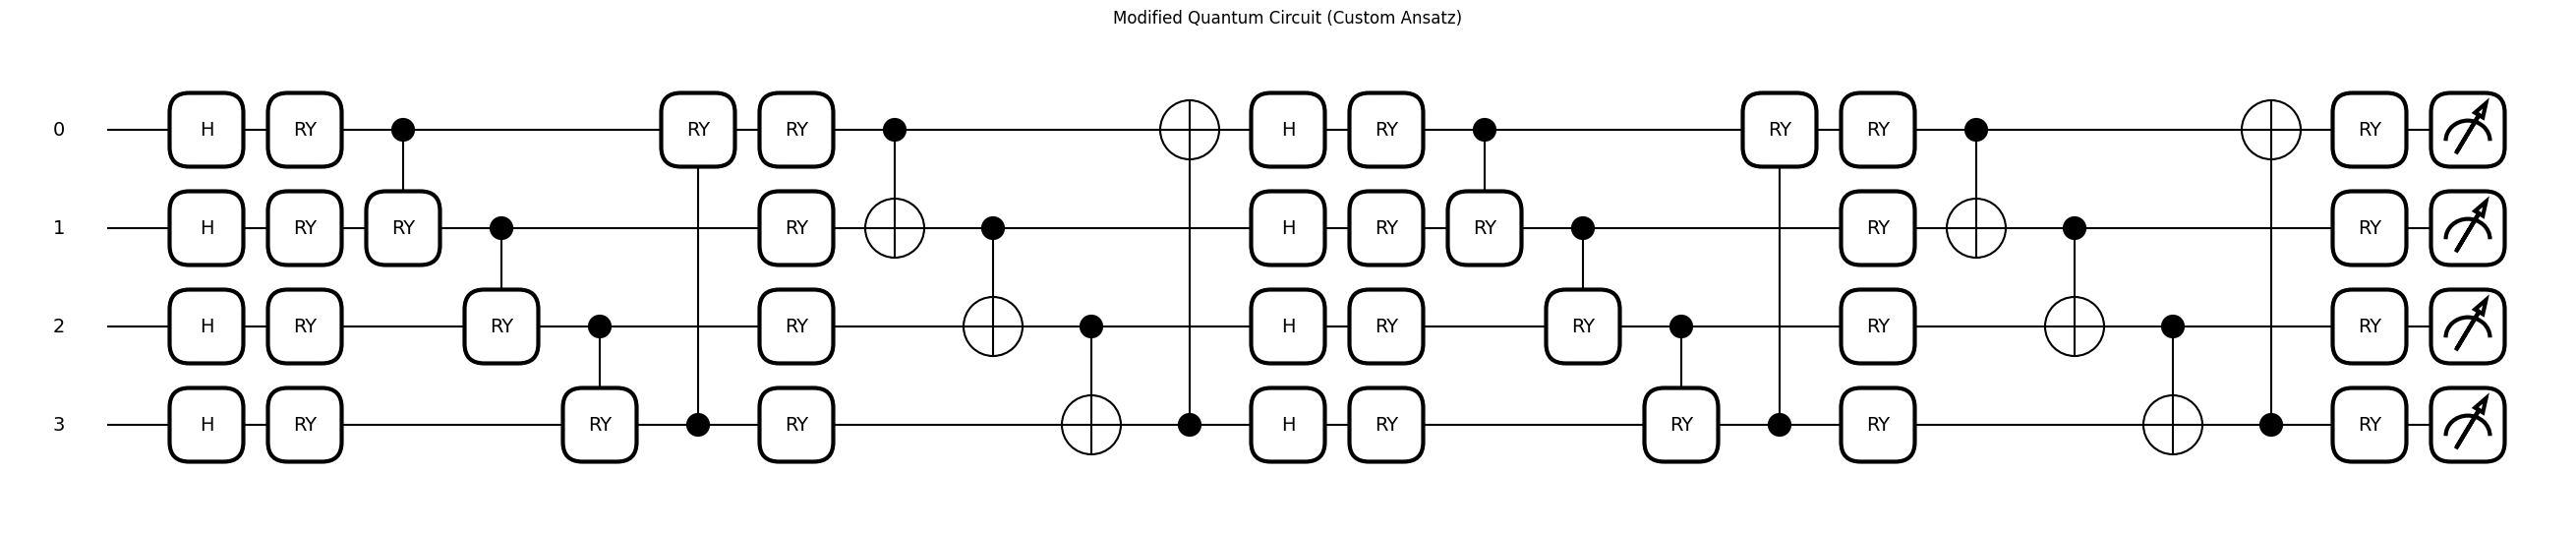

In [39]:
dummy_x = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float64).to(device)
specs = qml.specs(bc.qnn)(dummy_x)
total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)

# 양자 회로 그리기
fig, ax = qml.draw_mpl(bc.qnn)(dummy_x)
plt.title("Modified Quantum Circuit (Custom Ansatz)")
plt.show()

In [40]:
pprint.pprint(specs, width=1)
print(total_params)
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

{'device_name': 'default.qubit',
 'diff_method': 'best',
 'errors': {},
 'gradient_fn': 'backprop',
 'gradient_options': {},
 'interface': 'torch',
 'level': 'gradient',
 'num_device_wires': 4,
 'num_observables': 4,
 'num_tape_wires': 4,
 'num_trainable_params': 12,
 'resources': Resources(num_wires=4,
                        num_gates=44,
                        gate_types=defaultdict(<class 'int'>,
                                               {'CNOT': 8,
                                                'CRY': 8,
                                                'Hadamard': 8,
                                                'RY': 20}),
                        gate_sizes=defaultdict(<class 'int'>,
                                               {1: 28,
                                                2: 16}),
                        depth=23,
                        shots=Shots(total_shots=None, shot_vector=()))}
49534
✅ 회로 제약 통과 — 학습을 계속합니다


In [41]:
def train_step(epochs=10, lr=0.0010, weight_decay=1e-6):
    optimizer = AdamW(bc.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func  = NLLLoss()

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)

    loss_history = []
    bc.train()


    print(f"Starting training on {device}...")
    for epoch in range(epochs):
        epoch_bar = tqdm(enumerate(train_loader),
                        desc=f"Epoch {epoch+1}/{epochs}",
                        total=len(train_loader),
                        leave=True)

        total_loss = []
        for bidx, (data, target) in epoch_bar:
            data = data.to(device)
            target = target.to(device).flatten().long()
            #target = target.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad(set_to_none=True)

            output = bc(data)
            loss = loss_func(output, target)

            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

            if bidx % 100 == 0:
                epoch_bar.set_postfix(batch=bidx,
                                    loss=f"{loss.item():.4f}",
                                    lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        avg_loss = sum(total_loss) / len(total_loss)
        loss_history.append(avg_loss)

        print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] Loss: {avg_loss:.4f}")
        
    return loss_history


In [42]:
def test():
    print(f"Starting inference on {device}...")
    bc.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(test_loader,
                                desc="Inference",
                                total=len(test_loader),
                                leave=False):
            data, target = data.to(device), target.to(device).flatten().long() #target.to(device).float().unsqueeze(1)

            logits = bc(data)

            pred = logits.argmax(dim=-1)
            #probabilities = torch.sigmoid(logits)
            #pred = (probabilities >= 0.5).float().squeeze(1) 

            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())

    y_pred = torch.cat(all_preds).numpy().astype(int)
    y_true = torch.cat(all_targets).numpy().astype(int)

    #y_pred = torch.cat(all_preds).numpy().flatten().astype(int) # .flatten() 추가
    #y_true = torch.cat(all_targets).numpy().flatten().astype(int) # .flatten() 추가

    # --- 8. 평가 및 결과 저장 ---
    # 베이스라인 평가 로직을 따릅니다. y_true는 이제 10000개 길이를 가집니다.
    test_mask = (y_true == 0) | (y_true == 6)

    print("total samples:", len(y_true))
    print("target samples:", test_mask.sum())

    # 모델 결과가 1인 것을 6으로 변경 (제출 형식에 맞게)
    y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

    # 정확도 계산은 0/6 라벨에 대해서만 수행
    acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
    print(f"accuracy (labels 0/6 only): {acc:.4f}")

    now = datetime.now().strftime("%Y%m%d_%H%M%S")

    y_pred_filename = f"y_pred_{now}.csv"

    return y_pred_mapped, y_pred_filename, acc



In [43]:
def plt_loss_history(loss_history, n_repeats, epochs_per_repeat):
    """
    학습 손실 이력을 시각화합니다.
    Args:
        loss_history (list): 에포크별 평균 손실 값 리스트
        n_repeats (int): train_step 함수의 총 반복 횟수 (n)
        epochs_per_repeat (int): 한 번의 train_step에서 에포크 수 (epochs)
    """
    total_epochs = n_repeats * epochs_per_repeat
    x_axis = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, loss_history)
    plt.title("Training Loss History")
    plt.xlabel("Total Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 사용 예시
# loss_history는 모든 반복(n)과 에포크(epochs)의 손실이 담긴 리스트
# loss_history = [ ... ]

# plt_loss_history(loss_history, n_repeats=15, epochs_per_repeat=20)

In [44]:
result = 0
best_result = 0
max_y_pred_filename = ""
best_n = 0
n = 0
epochs = 10
lr = 0.0015
loss_history = []

while result < 0.92:
    lr = 0.0015 * (0.80**n)
    loss_history.extend(train_step(epochs=epochs, lr=lr, weight_decay=batch_size * 1e-6))
    y_pred_mapped, y_pred_filename, result = test()
    print(f"Iteration {n+1}: Result = {result:.4f}")

    if result > best_result:
        best_result = result
        best_n = n
        max_y_pred_filename = y_pred_filename

    n += 1

Starting training on cuda...


Epoch 1/10:  57%|█████▊    | 138/240 [00:10<00:07, 13.09it/s, batch=100, loss=0.4623, lr=0.001493]


KeyboardInterrupt: 

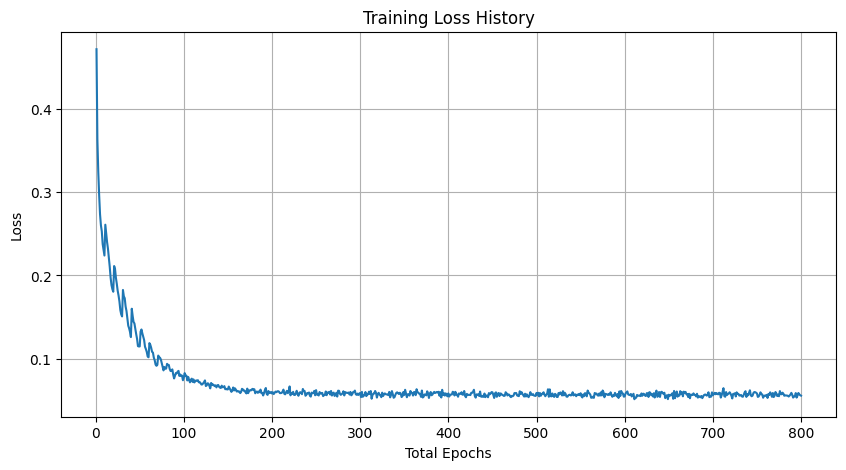

Best result: 0.8940 at iteration 3
Prediction saved to y_pred_20250809_014950.csv


In [ ]:
plt_loss_history(loss_history, n, epochs)
print(f"Best result: {best_result:.4f} at iteration {best_n}")
# 전체 10000개 샘플에 대한 예측을 저장 (대회 제출 형식)
np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
print(f"Prediction saved to {max_y_pred_filename}")